In [1]:
from adodbapi.ado_consts import directions
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters

from toolbar.masked import masked
from toolbar.significance_test import r_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import *


def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map


time = [1961, 2022]
heating = xr.open_dataset(r'E:\data\JRA55\JRA55_monthly_heating_1961_2023.nc').sel(time=slice(str(time[0]) + '-01', str(time[1]) + '-12'))
heating = heating.sel(time=heating['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'plev', 'lat', 'lon')
K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")

In [3]:
def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=6, colors='black')


reg_map, corr_map = np.zeros(
    (3, 5, len(heating.plev), len(heating.lat), len(heating.lon))), np.zeros(
    (3, 5, len(heating.plev), len(heating.lat), len(heating.lon)))

for i in tq.trange(len(K_type['type'])):
    K_series = K_type.sel(type=i + 1)['K'].data
    if i == 1: K_series = K_series - np.polyval(np.polyfit(range(len(K_series)), K_series, 1), range(len(K_series)))
    K_series = (K_series - np.mean(K_series)) / np.std(K_series)
    reg_map[i, 0], corr_map[i, 0] = regress(K_series, heating['var242'].data)
    reg_map[i, 1], corr_map[i, 1] = regress(K_series, heating['var241'].data)
    reg_map[i, 2], corr_map[i, 2] = regress(K_series, heating['var251'].data)
    reg_map[i, 3], corr_map[i, 3] = regress(K_series, heating['var250'].data)
    reg_map[i, 4], corr_map[i, 4] = regress(K_series, heating['var246'].data)
reg_map = xr.Dataset({'cnvhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 0]),
                      'lrghr': (['type', 'level', 'lat', 'lon'], reg_map[:, 1]),
                      'lwhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 2]),
                      'swhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 3]),
                      'vdfhr': (['type', 'level', 'lat', 'lon'], reg_map[:, 4])},
                     coords={'type': K_type['type'], 'level': heating.plev.data, 'lat': heating.lat, 'lon': heating.lon})
corr_map = xr.Dataset({'cnvhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 0]),
                       'lrghr': (['type', 'level', 'lat', 'lon'], corr_map[:, 1]),
                       'lwhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 2]),
                       'swhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 3]),
                       'vdfhr': (['type', 'level', 'lat', 'lon'], corr_map[:, 4])},
                      coords={'type': K_type['type'], 'level': heating.plev.data, 'lat': heating.lat, 'lon': heating.lon})


array([   100.,    200.,    300.,    500.,    700.,   1000.,   2000.,
         3000.,   5000.,   7000.,  10000.,  12500.,  15000.,  17500.,
        20000.,  22500.,  25000.,  30000.,  35000.,  40000.,  45000.,
        50000.,  55000.,  60000.,  65000.,  70000.,  75000.,  77500.,
        80000.,  82500.,  85000.,  87500.,  90000.,  92500.,  95000.,
        97500., 100000.])

100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


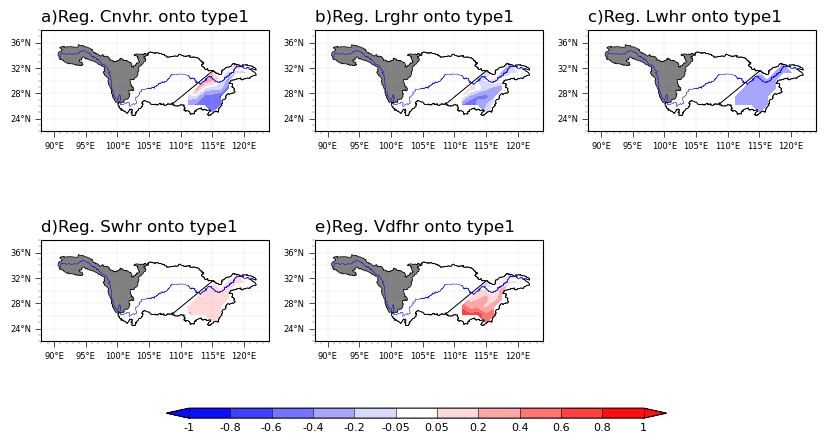

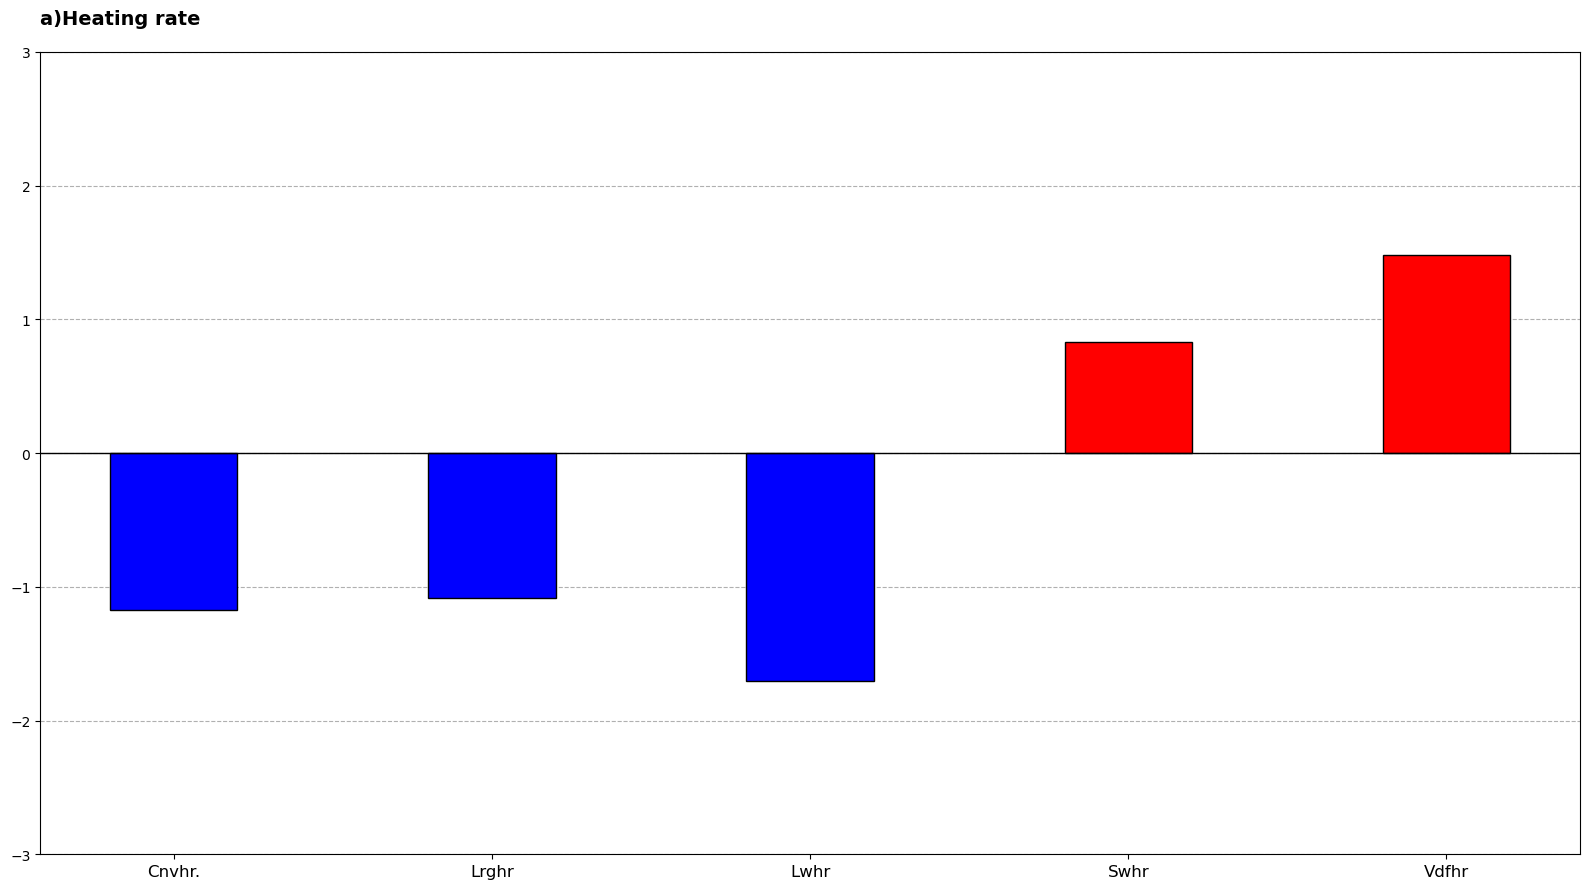

In [25]:
p_th = r_test(62, 0.05)  # 62为样本量，0.1为显著性水平
KType = 1
var = ['cnvhr', 'lrghr', 'lwhr', 'swhr', 'vdfhr']
var_out = [r'Cnvhr.', r'Lrghr', r'Lwhr', r'Swhr', r'Vdfhr']
if KType == 3:
    reg_map_ = masked(reg_map, r"D:\Code\work\Meteorological\p2\map\WYTR\长江_tp.shp")
elif KType == 1:
    reg_map_ = masked(reg_map, r"D:\Code\work\Meteorological\p2\map\EYTR\长江_tp.shp")
elif KType == 2:
    reg_map_ = masked(reg_map, r'D:\PyFile\map\self\长江_TP\长江_tp.shp')
reg = reg_map_.sel(type=KType, level=np.array([850, 900])*100).mean(dim='level')
corr = corr_map.sel(type=KType, level=np.array([850, 900])*100)
# 绘图
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0.2)
extent_CN = [88, 124, 22, 38]  # Increase vertical spacing between subplots
gs = gridspec.GridSpec(2, 3)
xticks1 = np.arange(extent_CN[0], extent_CN[1] + 1, 10)
yticks1 = np.arange(extent_CN[2], extent_CN[3] + 1, 10)

for ipic in tq.trange(5):
    ax1 = fig.add_subplot(gs[ipic], projection=ccrs.PlateCarree(central_longitude=180 - 70))
    ax1.set_title(f"{chr(ord('a') + ipic)})Reg. {var_out[ipic]} onto type{KType}", fontsize=12, loc='left')
    ax1.set_extent(extent_CN, crs=ccrs.PlateCarree(central_longitude=0))
    ####
    num_times = [6, 6, 6, 6, 6]
    lev_cnvhr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[0]
    lev_lrghr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[1]
    lev_lwhr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[2]
    lev_swhr = np.array([-1., -.8, -.6, -.4, -.2, -.05, .05, .2, .4, .6, .8, 1.]) * num_times[3]
    lev_vdfhr = np.array([-1., -.8, -.6, -.4, -.2, -.05,.05,.2,.4,.6,.8, 1.]) * num_times[4]
    lev = np.array([lev_cnvhr, lev_lrghr, lev_lwhr, lev_swhr, lev_vdfhr])
    #lev= 10
    contf = ax1.contourf(reg['lon'], reg['lat'], reg[var[ipic]] * 31,
                         cmap=cmaps.GMT_polar[0:9] + cmaps.CBR_wet[0] + cmaps.GMT_polar[11:],
                         levels=lev[ipic], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    '''# 在右上角添加标注 (坐标范围是轴坐标0-1)
    ax1.text(0.75, 1.03,
             fr'$\times {num_times[ipic]} K/month$',
             transform=ax1.transAxes,
             fontsize=10,
             color='black',
             bbox=dict(facecolor='none', alpha=0.0, edgecolor='none'))'''
    ####
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                       facecolor='none', edgecolor='black', linewidth=.5)
    ax1.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(),
                       ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
    ax1.add_geometries(Reader(
        r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(),
                       ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
    ax1.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(),
                       facecolor='none', edgecolor='blue', linewidth=0.2)
    ax1.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)
    latlon_fmt(ax1, xticks1, yticks1, MultipleLocator(5), MultipleLocator(1), MultipleLocator(4), MultipleLocator(1))
    # 色条
ax1_colorbar = fig.add_axes([0.25, 0.03, 0.5, 0.02])
cb1 = plt.colorbar(contf, cax=ax1_colorbar, orientation='horizontal', drawedges=True)
cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
cb1.dividers.set_color('black')  # 将colorbar内间隔线调为黑色
cb1.locator = ticker.FixedLocator(lev[ipic])
cb1.set_ticklabels(['-1', '-0.8', '-0.6', '-0.4', '-0.2', '-0.05', '0.05', '0.2', '0.4', '0.6', '0.8', '1'])
cb1.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度
plt.savefig(f'D:/PyFile/p2/pic/辐射收支type{KType}.pdf', dpi=600, bbox_inches='tight')
plt.show()

cnvhr = np.nanmean(reg['cnvhr'])* 31
lrghr = np.nanmean(reg['lrghr'])* 31
lwhr = np.nanmean(reg['lwhr'])* 31
swhr = np.nanmean(reg['swhr'])* 31
vdfhr = np.nanmean(reg['vdfhr'])* 31

# 在计算完三个变量之后添加以下代码

# 准备绘图数据
variables = ['cnvhr', 'lrghr', 'lwhr', 'swhr', 'vdfhr']
values = [cnvhr, lrghr, lwhr, swhr, vdfhr]
colors = ['red' if val > 0 else 'blue' for val in values]

# 创建柱状图
fig, ax = plt.subplots(figsize=(16, 9))
# 添加标题和网格
ax.set_title('a)Heating rate', pad=20, fontsize=14, fontweight='bold', loc='left')
ax.grid(True, linestyle='--', zorder=0, axis='y')

bars = ax.bar(range(5), values, width=0.4, color=colors, edgecolor='black', zorder=2)

# 设置坐标轴标签
ax.set_xticks(range(5))
ax.set_xticklabels([i for i in var_out], fontsize=12)

# 设置y轴范围
ymax = 3
ax.set_ylim(-ymax, ymax)

# 添加零线
ax.axhline(0, color='black', lw=1)

plt.tight_layout()
plt.savefig(f'D:/PyFile/p2/pic/辐射收支type{KType}_bar.pdf', dpi=600, bbox_inches='tight')
plt.show()